In [1]:
#import required packages

%matplotlib inline
import tensorflow as tf
import gpflow
import numpy as np
from multi_spectralmixture import MultiSpectralMixture as MOSM
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn 
seaborn.set(style="white", color_codes=True)

/home/gabriel/.conda/envs/gpflow1.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


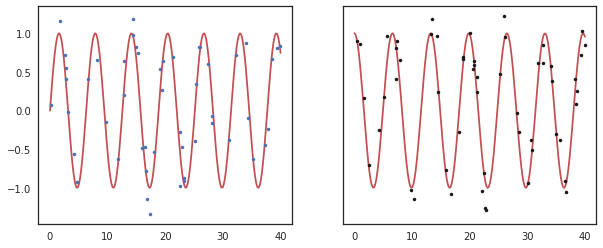

In [2]:
#Generation of input data, feel free to generate/import your own data. 

#latent process
N_sample = 200
X_latent = np.linspace(0, 40, N_sample)
f1 = np.sin(X_latent) 
f2 = np.cos(0.95*X_latent) 

#observations
N1 = 50
N2 = 55
X1_obs = np.random.uniform(0, 40, N1)
X2_obs = np.random.uniform(0, 40, N2)
Y1 = np.sin(X1_obs)  + 0.2*np.random.randn(N1)
Y2 = np.cos(0.95*X2_obs)  + 0.2*np.random.randn(N2)

#plot

fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
axes[0].plot(X_latent, f1, 'r-')
axes[0].plot(X1_obs, Y1, 'b.', lw=3)
axes[1].plot(X_latent, f2, 'r-')
axes[1].plot(X2_obs, Y2, 'k.', lw=3)

In [3]:
# Format input data
X_input = np.vstack([np.column_stack([np.zeros_like(Y1), X1_obs]), 
                  np.column_stack([np.ones_like(Y2), X2_obs])])
Y_input = np.hstack([Y1, Y2])[:, None]

X_latent_input = np.vstack([np.column_stack([np.zeros_like(X_latent), X_latent]), 
                  np.column_stack([np.ones_like(X_latent), X_latent])])


#set data dimensions
INPUT_DIM = 1
N_OUTPUTS = 2

#uncomment the following lines to set initial valued for the hyperparameters (not required)
#weights_init = np.ones(N_OUTPUTS)
#means_init = 0.5 * np.ones(N_OUTPUTS)[None, :]
#var_init = np.ones(N_OUTPUTS)[None, :]
#delay_init = np.zeros(N_OUTPUTS)[None, :]
#phase_init = np.zeros(N_OUTPUTS)

#kern = MOSM(1, N_OUTPUTS, weights_init, 
#            means_init, var_init, 
#            delay_init, phase_init)


#Set the number of components
number_of_components = 2
kern = MOSM(INPUT_DIM, N_OUTPUTS)
for i in range(number_of_components-1):
        kern += MOSM(INPUT_DIM, N_OUTPUTS)
        
#instantiate model
model = gpflow.models.GPR(X_input, Y_input, kern)
model.likelihood.variance = 0.5

In [4]:
gpflow.train.ScipyOptimizer().minimize(model, disp=True, maxiter=500)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -2.683560
  Number of iterations: 384
  Number of functions evaluations: 443


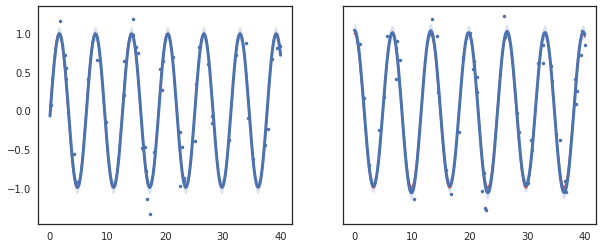

In [5]:
Y_star, STD_star = model.predict_y(X_latent_input)  #predict at inputs given by X_obs

fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
axes[0].plot(X_latent, f1, 'r-')
axes[0].plot(X1_obs, Y1, 'b.', lw=3)
axes[0].plot(X_latent, Y_star[:N_sample], 'b-', lw=3)
axes[0].fill_between(X_latent, (Y_star[:N_sample]-2*STD_star[:N_sample]).reshape([-1]), 
                     (Y_star[:N_sample]+2*STD_star[:N_sample]).reshape([-1]), alpha=0.2) 

axes[1].plot(X_latent, f2, 'r-')
axes[1].plot(X2_obs, Y2, 'b.', lw=3)
axes[1].plot(X_latent, Y_star[N_sample:], 'b-', lw=3)
axes[1].fill_between(X_latent, (Y_star[N_sample:]-2*STD_star[N_sample:]).reshape([-1]), 
                     (Y_star[N_sample:]+2*STD_star[N_sample:]).reshape([-1]), alpha=0.2) 

In [6]:
print(model)

<Parameter name:GPR/kern/multispectralmixture_1/constant [trainable] shape:(2,) transform:(none) prior:None>
value: [  6.2849451 ,  14.66578192]

<Parameter name:GPR/kern/multispectralmixture_1/mean [trainable] shape:(1, 2) transform:(none) prior:None>
value: [[-1.00265717, -0.94966448]]

<Parameter name:GPR/kern/multispectralmixture_1/variance [trainable] shape:(1, 2) transform:+ve prior:None>
value: [[  1.00411089e-06,   1.00000941e-06]]

<Parameter name:GPR/kern/multispectralmixture_1/delay [trainable] shape:(1, 2) transform:PartiallyFixed prior:None>
value: [[ 0.        ,  4.70101343]]

<Parameter name:GPR/kern/multispectralmixture_1/phase [trainable] shape:(2,) transform:PartiallyFixed prior:None>
value: [ 0.        ,  5.87367084]

<Parameter name:GPR/kern/multispectralmixture_2/constant [trainable] shape:(2,) transform:(none) prior:None>
value: [ 12.33707946,  -0.88630049]

<Parameter name:GPR/kern/multispectralmixture_2/mean [trainable] shape:(1, 2) transform:(none) prior:None>
